In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
import seaborn as sns
from typing import Callable
from scipy.stats import ortho_group
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from src.dt_helpers.network_dynamics import run_dynamics_step
from src.dt_helpers.plotters import visualize_network_activity
from src.dt_helpers.network_dynamics import compute_individual_neuron_frequency

np.set_printoptions(precision=4, suppress=True)

In [3]:
def plot_eigenvals(eigenvalues):
    fig, ax = plt.subplots()
    min_lim = np.floor(np.minimum(eigenvalues.real.min(), eigenvalues.imag.min()))
    max_lim = np.ceil(np.maximum(eigenvalues.real.max(), eigenvalues.imag.max()))
    ax.scatter(eigenvalues.real, eigenvalues.imag, s=20, marker="x", color="k")
    for i in range(eigenvalues.shape[0]):
        if eigenvalues[i].imag > 0 and eigenvalues[i].real > 0:
            ax.add_patch(
                Wedge(
                    (0, 0),
                    1,
                    0,
                    np.arctan2(eigenvalues[i].imag, eigenvalues[i].real) / (2 * np.pi) * 360,
                    ec="none",
                    fill=True,
                    color="k",
                    alpha=0.2,
                )
            )
    ax.add_patch(Circle((0, 0), 1, color="k", lw=0.5, fill=False))
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(min_lim, max_lim + 1, 1))
    ax.set_yticks(np.arange(min_lim, max_lim + 1, 1))
    sns.despine(offset=0, trim=True, ax=ax)
    return fig, ax

In [4]:
weights_minicircuit = np.load("../../data/MANC weights/20241118_T1Lminicircuit/W_20241118_T1Lminicircuit.npy")
table_minicircuit = pd.read_csv("../../data/MANC weights/20241118_T1Lminicircuit/wTable_20241118_T1Lminicircuit.csv")
minicircuit_size = (table_minicircuit["class"] != "motor neuron").sum()
send_connections = (weights_minicircuit[np.arange(minicircuit_size)] != 0).any(0)
receive_connections = (weights_minicircuit[:, np.arange(minicircuit_size)] != 0).any(1)
keep = send_connections | receive_connections
weights_minicircuit = weights_minicircuit[keep][:, keep]
table_minicircuit = table_minicircuit[keep]
weights_minicircuit[table_minicircuit["class"] == "motor neuron"] = 0

In [5]:
network_size = minicircuit_size
network_input = np.zeros(keep.sum())
network_input[table_minicircuit["class"] == "descending neuron"] = 1
network_input = network_input[table_minicircuit["class"] != "motor neuron"]

network_weights = weights_minicircuit[:network_size, :network_size].T
mean_gains = np.array([0.090, 0.170, 0.306, 0.508])
# mean_gains = table_minicircuit["size"].to_numpy() / table_minicircuit["size"].median()
network_weights = network_weights * mean_gains[:network_size][:, np.newaxis]
eigenvalues, _ = np.linalg.eig(network_weights)
# normalization_factor = eigenvalues[0].real
# normalization_factor = np.abs(eigenvalues).max()
# normalization_factor = np.abs(eigenvalues).max() / 2
# normalization_factor = 1
# normalization_factor = 1 / 0.275e-3
# normalization_factor = 1 / 0.03
tanh_gain_effect = 0.75
synaptic_re_weight = 0.03
normalization_factor = 1 / (synaptic_re_weight * tanh_gain_effect)
print(f"Normalization factor: {normalization_factor}")
network_weights = network_weights / normalization_factor

taus_s = 20e-3  # s
dt_s = 1e-3  # s

Normalization factor: 44.44444444444444


In [6]:
eigenvalues, eigenvectors = np.linalg.eig(network_weights)
print("eigenvals\n    ", eigenvalues)
print("eigenvals magnitude\n    ", np.abs(eigenvalues))
print("eigenvalues angle (rad)\n    ", np.arctan2(eigenvalues.imag, eigenvalues.real))
print("estimated frequencies (Hz)\n    ", np.arctan2(eigenvalues.imag, eigenvalues.real) / dt_s / (2 * np.pi))

eigenvals
     [ 0.8168+1.7571j  0.8168-1.7571j -1.6336+0.j      0.    +0.j    ]
eigenvals magnitude
     [1.9377 1.9377 1.6336 0.    ]
eigenvalues angle (rad)
     [ 1.1357 -1.1357  3.1416  0.    ]
estimated frequencies (Hz)
     [ 180.7462 -180.7462  500.        0.    ]


In [7]:
network_weights_star = (1 - dt_s / taus_s) * np.eye(network_size) + dt_s * network_weights / taus_s
eigenvalues_star, eigenvectors_star = np.linalg.eig(network_weights_star)
print("*** eigenvals\n    ", eigenvalues_star)
print("*** eigenvals magnitude\n    ", np.abs(eigenvalues_star))
print("*** eigenvalues angle (rad)\n    ", np.arctan2(eigenvalues_star.imag, eigenvalues_star.real))
print(
    "*** estimated frequencies (Hz)\n    ",
    np.arctan2(eigenvalues_star.imag, eigenvalues_star.real) / dt_s / (2 * np.pi),
)

*** eigenvals
     [0.9908+0.0879j 0.9908-0.0879j 0.8683+0.j     0.95  +0.j    ]
*** eigenvals magnitude
     [0.9947 0.9947 0.8683 0.95  ]
*** eigenvalues angle (rad)
     [ 0.0884 -0.0884  0.      0.    ]
*** estimated frequencies (Hz)
     [ 14.0751 -14.0751   0.       0.    ]


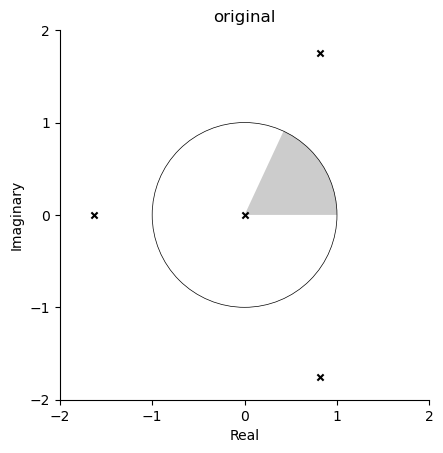

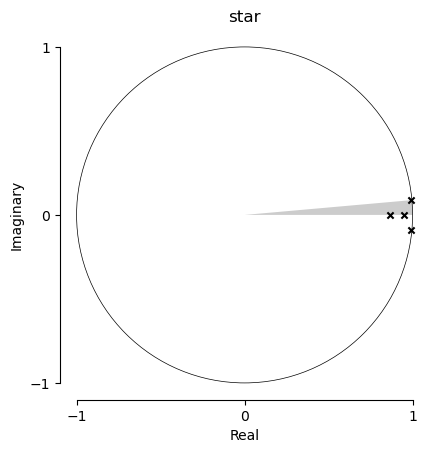

In [8]:
fig, ax = plot_eigenvals(eigenvalues)
ax.set_title("original")
plt.show()

fig, ax = plot_eigenvals(eigenvalues_star)
# plt.savefig("eigenvals.svg")
ax.set_title("star")
plt.show()

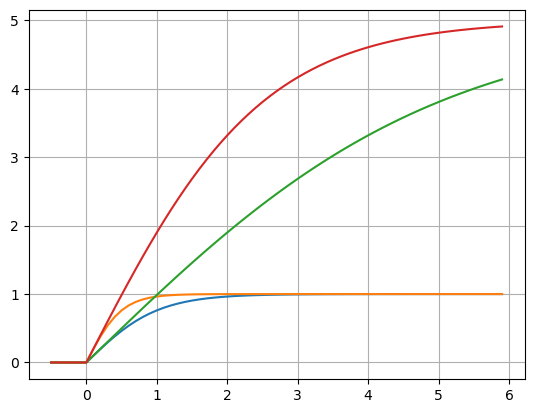

In [9]:
my_fun = lambda x, a, rmax: np.maximum(0, np.tanh(a * x / rmax) * rmax)
x = np.arange(-0.5, 6, 0.1)
plt.plot(x, my_fun(x, 1, 1))
plt.plot(x, my_fun(x, 2, 1))
plt.plot(x, my_fun(x, 1, 5))
plt.plot(x, my_fun(x, 2, 5))
# plt.axis("equal")
plt.grid()
plt.show()

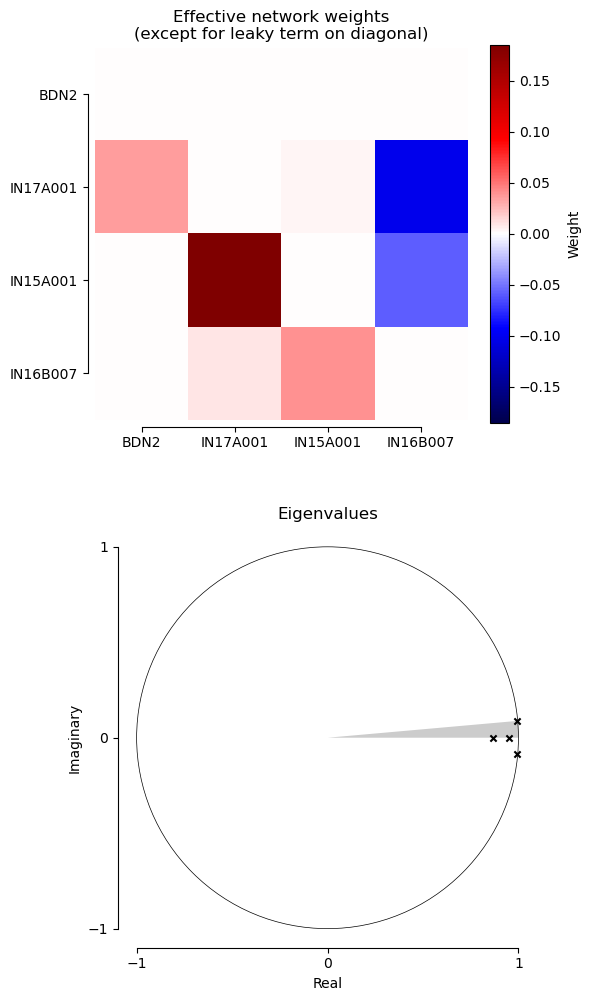

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(6, 12))

temp_net_weights = network_weights_star.copy()
temp_net_weights[np.arange(network_size), np.arange(network_size)] = 0
vval = np.abs(temp_net_weights).max()
ax = axes[0]
img = ax.imshow(temp_net_weights, cmap="seismic", vmin=-vval, vmax=vval)
ax.set_xticks(np.arange(network_size), table_minicircuit["type"][:network_size], rotation=90)
ax.set_yticks(np.arange(network_size), table_minicircuit["type"][:network_size])
ax.set_title("Effective network weights\n(except for leaky term on diagonal)")
sns.despine(offset=5, trim=True, ax=ax)
cbar = plt.colorbar(img, shrink=0.9, ax=ax)
cbar.ax.set_ylabel("Weight")

evals = eigenvalues_star
ax = axes[1]
min_lim = np.floor(np.minimum(evals.real.min(), evals.imag.min()))
max_lim = np.ceil(np.maximum(evals.real.max(), evals.imag.max()))
ax.scatter(evals.real, evals.imag, s=20, marker="x", color="k")
for i in range(evals.shape[0]):
    if evals[i].imag > 0 and evals[i].real > 0:
        ax.add_patch(
            Wedge(
                (0, 0),
                1,
                0,
                np.arctan2(evals[i].imag, evals[i].real) / (2 * np.pi) * 360,
                ec="none",
                fill=True,
                color="k",
                alpha=0.2,
            )
        )
ax.add_patch(Circle((0, 0), 1, color="k", lw=0.5, fill=False))
ax.set_title("Eigenvalues")
ax.set_xlabel("Real")
ax.set_ylabel("Imaginary")
ax.set_aspect("equal")
ax.set_xticks(np.arange(min_lim, max_lim + 1, 1))
ax.set_yticks(np.arange(min_lim, max_lim + 1, 1))
sns.despine(offset=0, trim=True, ax=ax)
plt.savefig("dynamical-system-analysis.svg", bbox_inches="tight")
plt.show()